In [4]:
import sys
from pathlib import Path
from addict import Dict as Adict
import pandas as pd
import seaborn as sns
import mdtraj as md
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')
from funcs_featurise import *
from funcs_db_assign import *
from funcs_indices import *
from funcs_plotting import *
from funcs_sample import *
from TrajData import TrajData
from MSMStudy import MSMStudy

plt.rcParams['xtick.labelsize'] = 14  # Font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-tick labels
plt.rcParams['legend.fontsize'] = 16  # Font size for legend
plt.rcParams['axes.labelsize'] = 18   # Font size for x-label and y-label
plt.rcParams['axes.titlesize'] = 18   # Font size for title

In [5]:
protein = 'abl'
key = 'abl-pdb-50ps' # Dataset key 
study = 'with_prior' # where the results are saved
data_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/data') # base dir

hps_df = pd.read_csv(data_path/f'{protein}'/'msm'/f'{study}'/'hps.csv')
TD = TrajData(protein = protein)
TD.add_dataset(rtraj_dir = Path(f'/arc/abl_processed/'), 
               ftraj_dir= data_path / f'{protein}'/ f'{key}' / 'ftrajs',
               dt=0.05,
               key=key)
study = MSMStudy(hps_table = hps_df,
                 traj_data = TD,
                 wk_dir = data_path/f'{protein}'/'msm'/f'{study}')
study.observation

Setting dataset <abl-pdb-50ps>. 
Number of raw trajectories: 749



,hp_id,time_consumed,is_sparse,ev_1,ev_2,ev_3,ev_4,ev_5,ev_6,ev_7,...,vamp2_std_2,vamp2_std_3,vamp2_std_4,vamp2_std_5,vamp2_std_6,vamp2_std_7,vamp2_std_8,vamp2_std_9,vamp2_std_10,vamp2_std_11
0,1,1074.410517,False,1.0,0.999890,0.999787,0.999782,0.999431,0.999369,0.997438,...,0.000140,0.000156,0.000186,0.000216,0.000257,0.000260,0.000290,0.000322,0.000335,0.003066
1,2,1013.094291,False,1.0,0.999886,0.999787,0.999762,0.999428,0.999368,0.997492,...,0.000135,0.000173,0.000192,0.000191,0.000224,0.000230,0.000256,0.000274,0.000279,0.003603
2,3,1017.254637,False,1.0,0.999891,0.999773,0.999725,0.999414,0.999363,0.997478,...,0.000178,0.000186,0.000219,0.000225,0.000256,0.000261,0.000279,0.000296,0.000310,0.000672
3,4,984.530003,False,1.0,0.999879,0.999758,0.999714,0.999405,0.999334,0.997464,...,0.000121,0.000171,0.000287,0.000222,0.000255,0.000262,0.000287,0.000306,0.000309,0.001657
4,5,3786.938161,False,1.0,0.999802,0.999065,0.998065,0.997963,0.997724,0.997167,...,0.000023,0.000032,0.000200,0.000305,0.000257,0.000259,0.000303,0.000339,0.000356,0.000374


In [6]:
study.set_hp_id(4)

Set dataset abl-pdb-50ps stride to 1
Loading MSM model id 4 from /home/rzhu/Desktop/projects/kinase_analysis/data/abl/msm/with_prior/4
{'hp_id': 4, 'datasets': 'abl-pdb-50ps', 'features': 'dbdist dbdihed achelix aloop', 'dt_out': 0.05, 'time_cutoff': 100, 'tica_lag_time': 1, 'tica_stride': 1000, 'tica_dim': 20, 'tica_kinetic_map': True, 'cluster_n': 1000, 'cluster_stride': 1000, 'cluster_max_iter': 1000, 'seed': 42, 'markov_lag_time': 100, 'markov_count_mode': 'effective', 'markov_count_prior': True, 'msm_mode': 'bayesian'}
Loading trajectories...
Loading models...
Done


In [7]:
study.run_pcca(6)

In [80]:
traj_all = study.ttraj_cat
dim_1 = 0
dim_2 = 1
traj_weights = np.concatenate(study.traj_weights, axis=0)
fes_cmap = 'nipy_spectral'
n_states = 6
c_centers = study.kmeans_centers[study.connected_states, :]
pcca_assignment = study.pcca_mod.assignments
stat_dist = study.msm_mod.stationary_distribution

In [81]:
macrostate_centroid = []
for i in range(n_states):
    macrostate_cluster_centers = c_centers[pcca_assignment == i, :]
    macrostate_cluster_weights = stat_dist[pcca_assignment == i]
    weighted_centroid = np.average(macrostate_cluster_centers, axis=0, weights=macrostate_cluster_weights)
    macrostate_centroid.append(weighted_centroid)
pos = {i:(macrostate_centroid[i][dim_1], macrostate_centroid[i][dim_2]) for i in range(n_states)}

In [82]:
cg_stationary_dist = [sum(stat_dist[pcca_assignment == i]) for i in range(n_states)]
node_sizes = cg_stationary_dist/min(cg_stationary_dist)*100
node_ln_widths = np.cbrt(node_sizes/min(node_sizes))
node_ft_sizes = np.cbrt(node_sizes/min(node_sizes))*8

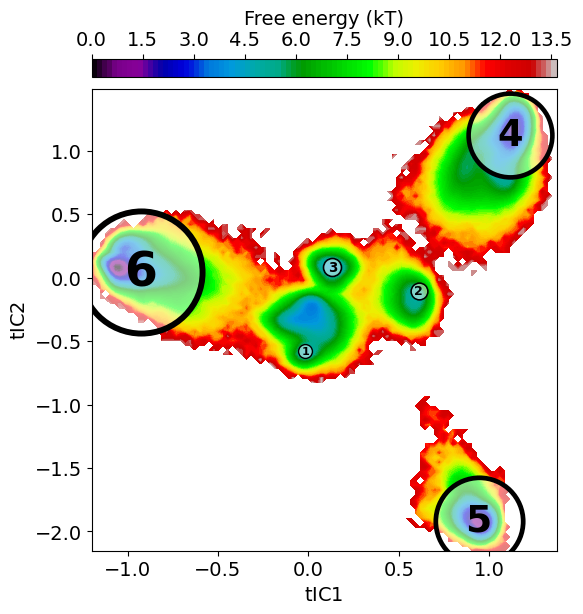

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(6, 6))

# Plot the energy surface
ax, contour, cbar = plot_energy2d(
    energy2d(traj_all[:, dim_1], traj_all[:, dim_2], weights=traj_weights),
    ax=ax,
    contourf_kws=dict(cmap=fes_cmap),
    cbar=False  # Horizontal colorbar
)

# Get the position of the main plot
ax_pos = ax.get_position()

# Create a new colorbar axis aligned with the main plot
cbar_height = 0.03  # Height of the colorbar
cbar_ax = fig.add_axes([ax_pos.x0, ax_pos.y1 + 0.02, ax_pos.width, cbar_height])  # [left, bottom, width, height]

cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_xlabel(r'Free energy (kT)', fontsize=14)

for i, (n, (x, y)) in enumerate(pos.items()):
    ax.scatter(
        x, y, 
        s=node_sizes[n], 
        facecolors=(1, 1, 1, 0.5),
        edgecolors='black', 
        linewidths=node_ln_widths[n]
    )
    ax.text(
        x, y, 
        str(n+1),  # Label inside the circle
        fontsize=node_ft_sizes[n], 
        ha='center', va='center', 
        fontweight='bold'
    )

# legend_handles = []
# for n in pos:
#     circle_patch = mpatches.Circle(
#         (0, 0), 1,  # Placeholder location and size
#         edgecolor='black',
#         label=f'Node {n}'  # Custom label text for the legend
#     )
#     legend_handles.append(circle_patch)
# ax.legend(handles=legend_handles)


# Set axis labels
ax.set_xlabel(fr'$\mathrm{{tIC}}{dim_1+1}$', fontsize=14)
ax.set_ylabel(fr'$\mathrm{{tIC}}{dim_2+1}$', fontsize=14)

plt.savefig('fig2a_abl.pdf', bbox_inches='tight')
plt.show()

In [8]:
# Load the precomputed Dunbrack states assignment 
# hdbscan_dist_group / hdbscan_dihed_group -- used hdbscan
# distgroup / dihedgroup -- used average-linkage hierachical clustering 

TD.load_ftrajs(key=key,
               feature_names=['hdbscan_dist_group', 'hdbscan_dihed_group'],)
distgroup, _ = TD.get_ftrajs(keys=key, 
                             dt_out=0.05, 
                             internal_names=['hdbscan_dist_group'], 
                             time_cutoff=0,
                             convert_dihed_ids=None)
dihedgroup, _ = TD.get_ftrajs(keys=key, 
                              dt_out=0.05, 
                              internal_names=['hdbscan_dihed_group'], 
                              time_cutoff=0,
                              convert_dihed_ids=None)
distgroup_cat = np.concatenate(distgroup).flatten()
dihedgroup_cat = np.concatenate(dihedgroup).flatten()

sim_ptraj_cat = np.array([study.micro_to_macro[d] if d in study.connected_states else -1 for d in study.dtraj_cat])

abl-pdb-50ps
Loading feature:  hdbscan_dist_group


  0%|          | 0/749 [00:00<?, ?it/s]

100%|██████████| 749/749 [00:00<00:00, 13450.59it/s]


Loading feature:  hdbscan_dihed_group


100%|██████████| 749/749 [00:00<00:00, 8875.97it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 17273.42it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 18415.70it/s]


In [24]:
sum(dihed_counts,[])

[6935, 0, 0, 309, 0, 40, 27032, 9, 7, 560, 2264, 72243]

In [ ]:
dihed_cluster_labels = ['noise', 
                        'noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 
                        'noise', 'BABtrans', 
                        'noise', 'BBAminus']
for state_i in range(study.pcca_n):
    frame_indices = np.where(sim_ptraj_cat == state_i)[0]
    spatial_assignments, dihed_assignments = distgroup_cat[frame_indices], dihedgroup_cat[frame_indices]
    
    spatial_counts, dihed_counts = dunbrack_count(spatial_assignments, dihed_assignments)
    dihed_counts = sum(dihed_counts,[])
    
    print(f'State {state_i+1}:')
    print(f'{spatial_counts/np.sum(spatial_counts)}')
    print(f'{dihed_counts/np.sum(spatial_counts)}')

    print('DFG-in')
    dfgin = np.array([dihed_counts[i] for i in range(1,8)])
    print(f'{np.argmax(dfgin)} ({np.max(dfgin)/np.sum(dihed_counts):.3f})')
    print(f'Other ({np.sum(dfgin) - np.max(dfgin) /np.sum(dihed_counts):.3f})')

    print('DFG-inter')
    dfginter = np.array([dihed_counts[i] for i in range(8, 10)])
    print(f'BABtrans ({np.max(dfginter)/np.sum(dihed_counts):.3f})')
    print(f'Noise ({np.sum(dfgin) - np.max(dfgin) /np.sum(dihed_counts):.3f})')

    print('DFG-out')
    dfgout = np.array([dihed_counts[i] for i in range(10,12)])
    print(f'BBAminus ({np.max(dfgin)/np.sum(dihed_counts):.3f})')
    print(f'Noise ({np.sum(dfgin) - np.max(dfgin) /np.sum(dihed_counts):.3f})')

State 1:
[0.0633918  0.25036792 0.00518286 0.68105741]
[6.33918043e-02 0.00000000e+00 0.00000000e+00 2.82452308e-03
 0.00000000e+00 3.65634055e-04 2.47095494e-01 8.22676624e-05
 6.39859597e-05 5.11887677e-03 2.06948875e-02 6.60362526e-01]
BBAminus (0.660)
BLBplus (0.247)

State 2:
[8.61651259e-01 0.00000000e+00 3.79495120e-05 1.38310791e-01]
[8.61651259e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.03596096e-05 7.58990239e-06 3.42304598e-03 1.34887745e-01]
noise (0.862)
BBAminus (0.135)

State 3:
[0.09871688 0.         0.0040516  0.89723152]
[0.09871688 0.         0.         0.         0.         0.
 0.         0.         0.00135983 0.00269177 0.0053696  0.89186192]
BBAminus (0.892)
noise (0.099)

State 4:
[0.24274948 0.13765953 0.1110772  0.50851379]
[2.42749476e-01 1.68018297e-05 1.02821394e-01 6.78182946e-05
 0.00000000e+00 3.05487814e-07 3.47159406e-02 3.72695133e-05
 3.18489375e-02 7.92282645e-02 1.58665177e-01 3.4

In [ ]:
nts,[])/np.sum(spatial_counts)}:.3f')
    # Print the name and population of the most and second most populated Dunbrack state
    print(f'{dunbrack_names[np.argmax(spatial_counts)]} ({np.max(spatial_counts)/np.sum(spatial_counts):.3f})')
    print(f'{dunbrack_names[np.argsort(spatial_counts)[-2]]} ({np.sort(spatial_counts)[-2]/np.sum(spatial_counts):.3f})')
    print('')

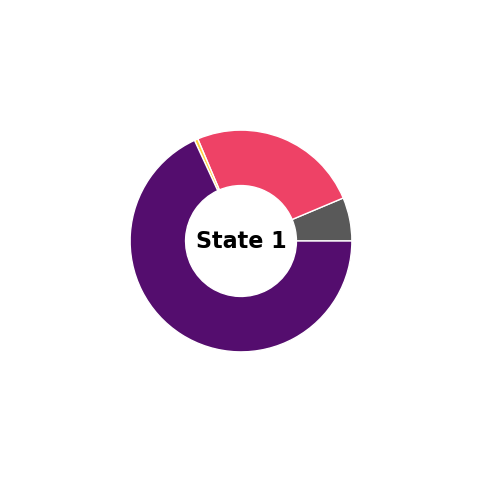

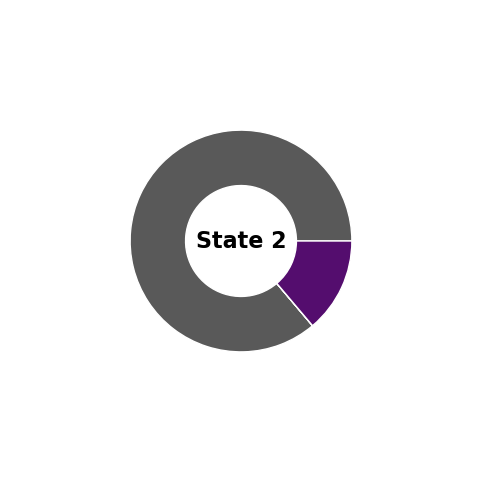

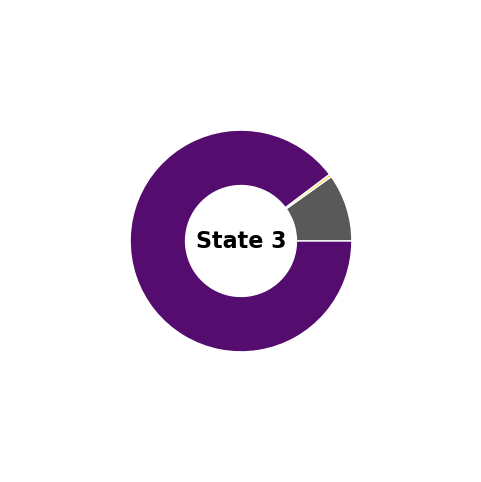

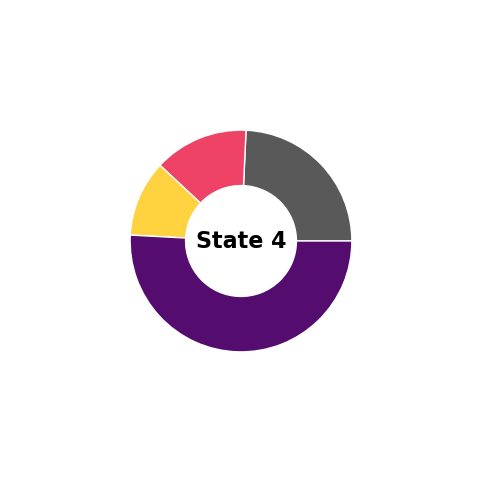

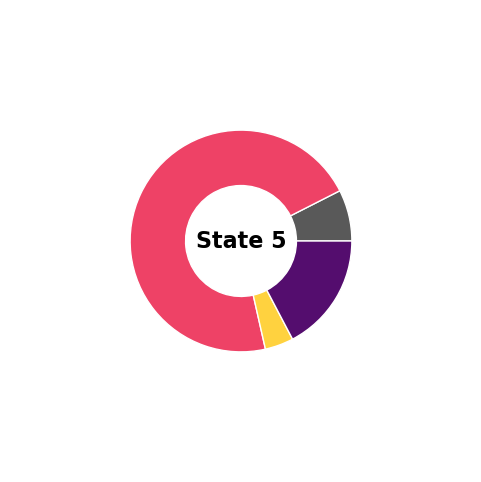

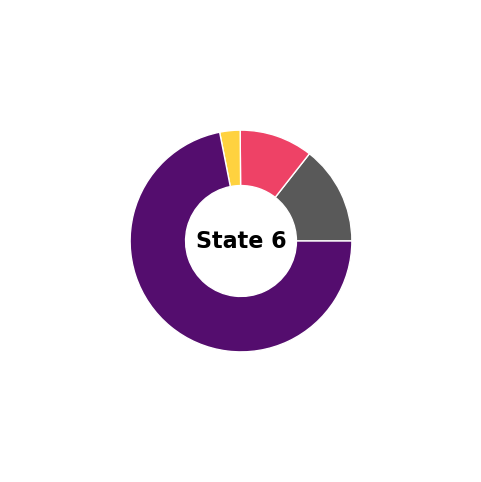

In [15]:
for state_i in range(study.pcca_n):
    frame_indices = np.where(sim_ptraj_cat == state_i)[0]
    spatial_assignments, dihed_assignments = distgroup_cat[frame_indices], dihedgroup_cat[frame_indices]
    
    spatial_counts, dihed_counts = dunbrack_count(spatial_assignments, dihed_assignments)
    plot_dihed_pie(spatial_counts, dihed_counts, 
                   radius_size=0.3, show_legend=False, show_dihed=False,
                   title=f'State {state_i+1}', 
                   savedir=f'state_{state_i+1}_dihed.pdf')

Show all simulation datapoints and crystal starting points

In [9]:

crystal_files = natsorted([str(f) for f in Path(f"/arc/human_{protein}/").glob("kinoml*.pdb")])
print('Number of crystal structures:', len(crystal_files))

frames = [] 
for crystal in crystal_files:
    sample_frame = md.load(crystal)
    sample_frame = sample_frame.atom_slice(sample_frame.top.select('mass>1.1'))
    frames.append(sample_frame)
crystals = md.join(frames)
crystals = crystals.superpose(crystals, 0)

featurisers = [dbdist_featuriser, dbdihed_featuriser, aloop_featuriser, achelix_featuriser]
c_ftrajs_dict = {f.__name__.split('_')[0]:[f(traj=crystals, protein=protein)] for f in featurisers}
c_ftrajs, _ = TD.prepare_ftrajs(c_ftrajs_dict, stride=1, frame_no_cutoff=0, convert_dihed_ids=[1])
c_ttraj, dtraj, connected_d, c_disconnected_d, c_pcca_assignment = study.transform(c_ftrajs)
c_dist_group, c_dihed_group = dfg_featuriser(traj=crystals, protein=protein)

Number of crystal structures: 83
Preparing feature trajectories...


100%|██████████| 1/1 [00:00<00:00, 10155.70it/s]


In [10]:
TD.load_ftrajs(key=key,
               feature_names=['dbdist'])

dbdist, _ = TD.get_ftrajs(keys=key, 
                          dt_out=0.05, 
                          internal_names=['dbdist'], 
                          time_cutoff=0,
                          convert_dihed_ids=None)

dbdist_cat = np.concatenate(dbdist, axis=0)

abl-pdb-50ps
Loading feature:  dbdist


  0%|          | 0/749 [00:00<?, ?it/s]

100%|██████████| 749/749 [00:00<00:00, 8057.26it/s]


Stride for dataset abl-pdb-50ps with timestep 0.05 ns: 1
Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 18300.69it/s]


In [11]:
import matplotlib.lines as mlines

def plot_fig(x, y, c, xc, yc, cc,x_label, y_label, fname, show_legend=True):
    fig, ax = plt.subplots(figsize=(6, 8))

    scatter = ax.scatter(x, y, c=c, s=0.3, alpha=0.5)
    scatter_crystal = ax.scatter(xc, yc, c=cc, s=20, edgecolors='black', linewidths=1)
    
    
    legend_patches = [
    mlines.Line2D([], [], marker='o', color='w', lw=0, markerfacecolor=dfg_spatial_colors[0], 
                  markersize=8, label="Noise"),
    mlines.Line2D([], [], marker='o', color='w', lw=0, markerfacecolor=dfg_spatial_colors[1], 
                  markersize=8, label="DFG-in"),
    mlines.Line2D([], [], marker='o', color='w', lw=0, markerfacecolor=dfg_spatial_colors[2], 
                  markersize=8, label="DFG-inter"),
    mlines.Line2D([], [], marker='o', color='w', lw=0, markerfacecolor=dfg_spatial_colors[3], 
                  markersize=8, label="DFG-out"),
    mlines.Line2D([], [], marker='o', color='w', lw=0, markerfacecolor='white', 
                  markeredgecolor='black', markersize=7, label="Seeds")
]    
    # legend_patches = [mpatches.Patch(color=dfg_spatial_colors[0], label = "Noise"),
    #                   mpatches.Patch(color=dfg_spatial_colors[1], label = "DFG-in"),
    #                   mpatches.Patch(color=dfg_spatial_colors[2], label = "DFG-inter"),
    #                   mpatches.Patch(color=dfg_spatial_colors[3], label = "DFG-out"),
    #                   mpatches.Patch(color='', label = "Seeds")]
    if show_legend:
        ax.legend(handles=legend_patches, loc="upper right")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(0.2, 2.2)
    ax.set_xticks(np.arange(0.2, 2.21, 0.5))
    ax.set_yticks(np.arange(0.2, 2.21, 0.5))
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

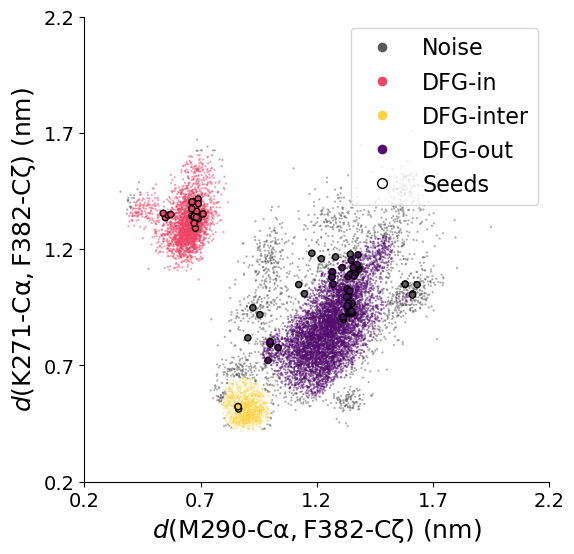

In [12]:
plot_fig(x = dbdist_cat[::1000, 0],
         y = dbdist_cat[::1000, 1],
         c = dfg_spatial_colors[distgroup_cat[::1000]+1],
         xc = c_ftrajs[0][:, 0],
         yc = c_ftrajs[0][:, 1],
         cc = dfg_spatial_colors[c_dist_group+1],
         x_label = r"$d(\mathrm{M290}\text{-C}\mathrm{\alpha}, \mathrm{F382}\text{-C}\mathrm{\zeta})$ (nm)",
         y_label = r"$d(\mathrm{K271}\text{-C}\mathrm{\alpha}, \mathrm{F382}\text{-C}\mathrm{\zeta})$ (nm)",
         show_legend = True,
         fname = 'fig2_crystals.pdf')

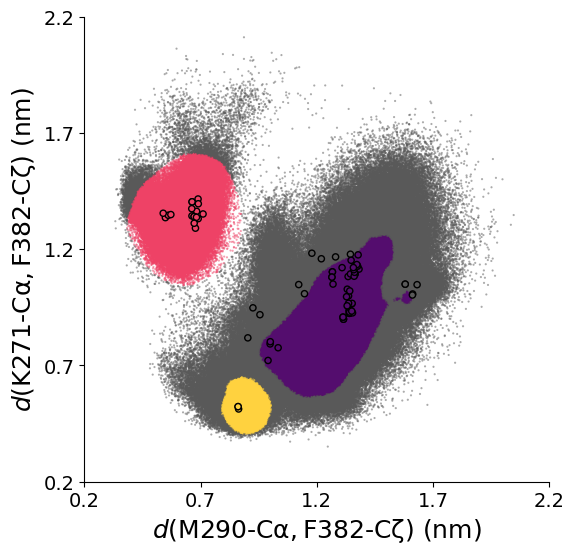

In [13]:
plot_fig(x = dbdist_cat[::10, 0],
         y = dbdist_cat[::10, 1],
         c = dfg_spatial_colors[distgroup_cat[::10]+1],
         xc = c_ftrajs[0][:, 0],
         yc = c_ftrajs[0][:, 1],
         cc = dfg_spatial_colors[c_dist_group+1],
         x_label = r"$d(\mathrm{M290}\text{-C}\mathrm{\alpha}, \mathrm{F382}\text{-C}\mathrm{\zeta})$ (nm)",
         y_label = r"$d(\mathrm{K271}\text{-C}\mathrm{\alpha}, \mathrm{F382}\text{-C}\mathrm{\zeta})$ (nm)",
         show_legend=False,
         fname = 'fig2_crystals.png')